## This notebook will get model outputs from the Community Firn Model to compare to the Summit data
### The notebook specifically runs through:
   ##### -Temperature adjustments
   ##### -Observed/modeled firn temperature
   ##### -Firn temperature difference/ 10m firn temperature difference
   ##### -Observed/modeled 10m firn temperature
   ##### -MERRA2 vs FirnCover Summit air temperature

In [1]:
### Import necessary python packages and CFM code.

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import scipy as sp
import pandas as pd
import netCDF4 as nc
import sys
import os
import pickle
import seaborn as sns 
import glob
import time
import json
import shutil
import xarray as xr
import copy
import tables as tb
import datetime
import calendar

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # turn off future warning for frame.append
pd.options.mode.chained_assignment = None # turn off chained assignment warning, default = 'warn'

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

from sklearn.metrics import mean_squared_error
import math
np.seterr(invalid='ignore')

SPY = 365.25*24*3600

try:
    sys.path.append('/Users/dswan1/Downloads/CFM/CommunityFirnModel/CFM_main')
except:
    pass

from firn_density_nospin import FirnDensityNoSpin
from siteClimate_from_RCM import getClimate #get data from RCM
from RCMpkl_to_spin import makeSpinFiles

In [2]:
# Default Settings for figures
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['figure.figsize'] = [10, 8]
palette = sns.color_palette()

In [3]:
def toYearFraction(date):
    '''
    convert datetime to decimal date 
    '''
    def sinceEpoch(date): # returns seconds since epoch
        return calendar.timegm(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime.datetime(year=year, month=1, day=1)
    startOfNextYear = datetime.datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

def decyeartodatetime(din):
    start = din
    rem, year = np.modf(din)
    base = datetime.datetime(int(year), 1, 1)
    result = base + datetime.timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result2 = result.replace(second=0, microsecond=0)
    return result2

In [4]:
R          = 8.314                          # gas constant used to calculate Arrhenius's term
S_PER_YEAR = 31557600.0                     # number of seconds in a year
spy = S_PER_YEAR
RHO_1      = 550.0                          # cut off density for the first zone densification (kg/m^3)
RHO_2      = 815.0                          # cut off density for the second zone densification (kg/m^3)
RHO_I      = 917.0                          # density of ice (kg/m^3)
RHO_I_MGM  = 0.917                          # density of ice (g/m^3)
RHO_1_MGM  = 0.550                          # cut off density for the first zone densification (g/m^3)
GRAVITY    = 9.8                            # acceleration due to gravity on Earth
K_TO_C     = 273.15                         # conversion from Kelvin to Celsius
BDOT_TO_A  = S_PER_YEAR * RHO_I_MGM         # conversion for accumulation rate
RHO_W_KGM  = 1000.                          # density of water
P_0 = 1.01325e5

## Look at the Physics Schemes for Summit Data

### You will need to change this cell to fit the lat/lon values and the filename prefix that you want

In [5]:
lat_int = 72.5 # latitude of interest
lon_int = -38.75 #longitude
# data_source = 'CFM_smetinput'
data_source = 'MERRA2_CLIM_df'

lat_val = lat_int
lon_val = lon_int

spin_date_st = 1980.0
spin_date_end = 2020.0

In [6]:
#Load the pkl files 

try:
    summit_df = pd.read_pickle(f'../Summit_compaction.pkl')
except:
    summit_df = pd.read_pickle(f'C:/Users/dswan1/Downloads/CFM/firncover/Summit_compaction.pkl')
try:
    compaction_df = pd.read_pickle(f'../compaction_df.pkl')
except:
    compaction_df = pd.read_pickle(f'C:/Users/dswan1/Downloads/CFM/firncover/compaction_df.pkl')

try:
    df_daily = pd.read_pickle(f'C:/Users/dswan1/Downloads/CFM/CommunityFirnModel/CFM_main/MERRA2_CLIM_df_{lat_val}_{lon_val}.pkl')
except:
    df_daily = pd.read_pickle(f'/Users/cdsteve2/research/firn/CommunityFirnModel/CFM_main/IDS/pickle/MERRA2_CLIM_df_{lat_int}_{lon_int}.pkl')
try:
    Summit_air_temp = pd.read_pickle(r'../Summit_air_temp.pkl')
    Summit_rtd_depths = pd.read_pickle(r'../Summit_rtd_depths.pkl') 
    Summit_sonic = pd.read_pickle(r'../Summit_sonic_ranger.pkl')
    Summit_temps = pd.read_pickle(r'../Summit_temperature_observed.pkl')
except:
    Summit_air_temp = pd.read_pickle(r'C:/Users/dswan1/Downloads/CFM/firncover/Summit_air_temp.pkl')
    Summit_rtd_depths = pd.read_pickle(r'C:/Users/dswan1/Downloads/CFM/firncover/Summit_rtd_depths.pkl') 
    Summit_sonic = pd.read_pickle(r'C:/Users/dswan1/Downloads/CFM/firncover/Summit_sonic_ranger.pkl')
    Summit_temps = pd.read_pickle(r'C:/Users/dswan1/Downloads/CFM/firncover/Summit_temperature_observed.pkl')

In [7]:
#You will also need to change t_adjust

t_adjust = 3
df_daily_adjusted = df_daily.copy()
df_daily_adjusted['TS'] = df_daily_adjusted['TS'] + t_adjust

In [8]:
# Load the model output for one specified model run

    #if you want to run multiple models, you can use the following:
        # fns = ['KuipersMunneke2015','GSFC2020']
        # fns = ['HLdynamic', 'Li2011']
        # fns = ['Morris2014', 'Crocus']
        # rvs = [315,325]

### Regular model output
fns = ['GSFC2020']
rvs = ['315']
rd = {} #results dictionary
for physics in fns:
    for rv in rvs:
        print('+++++++++++')
        print(physics)
        print(rv)
        ff = f'CFMoutputs/CFMresults_{lat_val}_{lon_val}_{physics}_{rv}_{spin_date_end}/CFMresults.hdf5'
        print(ff)
        with h5.File(ff,'r') as open_fn: # Open the CFM results file
            physics_rv = physics + '_' + str(rv)
            print(physics_rv)
            print('+++++++++++')
            vars_list = list(open_fn.keys()) # Make a list of the variables stored in the file
            # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
            # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
            rd[physics_rv] = {}
            rd[physics_rv]['model_time'] = open_fn['density'][1:,0]
            rd[physics_rv]['depth'] = open_fn['depth'][1:,1:] # Put the depth data into a numpy array
            rd[physics_rv]['density'] = open_fn['density'][1:,1:] # Put the density data into an array
            rd[physics_rv]['temperature'] = open_fn['temperature'][1:,1:]
            rd[physics_rv]['DIP'] = open_fn['DIP'][1:,1:]
            rd[physics_rv]['Dcon'] = open_fn['Dcon'][1:,1:]
            rd[physics_rv]['Datetime'] = pd.to_datetime([decyeartodatetime(iii) for iii in rd[physics_rv]['model_time']])

### Model output Plus t_adjust
rd2 = {} #results dictionary
for physics in fns:
    for rv in rvs:
        print('==========')
        print(physics)
        print(rv)
        ff2 = f'CFMoutputs/CFMresults_{lat_val}_{lon_val}_{physics}_{rv}_{spin_date_end}_Tplus{t_adjust}/CFMresults.hdf5'
        print(ff2)
        with h5.File(ff2,'r') as open_fn2: # Open the CFM results file
            physics_rv = physics + '_' + str(rv)
            print(physics_rv)
            print('==========')
            vars_list = list(open_fn2.keys()) # Make a list of the variables stored in the file
            # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
            # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
            rd2[physics_rv] = {}
            rd2[physics_rv]['model_time'] = open_fn2['density'][1:,0]
            rd2[physics_rv]['depth'] = open_fn2['depth'][1:,1:] # Put the depth data into a numpy array
            rd2[physics_rv]['density'] = open_fn2['density'][1:,1:] # Put the density data into an array
            rd2[physics_rv]['temperature'] = open_fn2['temperature'][1:,1:]
            rd2[physics_rv]['DIP'] = open_fn2['DIP'][1:,1:]
            rd2[physics_rv]['Dcon'] = open_fn2['Dcon'][1:,1:]
            rd2[physics_rv]['Datetime'] = pd.to_datetime([decyeartodatetime(iii) for iii in rd2[physics_rv]['model_time']])
        
x_df = rd[physics_rv]['model_time']
y_df = rd[physics_rv]['depth']
z_df = rd[physics_rv]['temperature']

x_df_Tplus = rd2[physics_rv]['model_time']
y_df_Tplus = rd2[physics_rv]['depth']
z_df_Tplus = rd2[physics_rv]['temperature']

+++++++++++
GSFC2020
315
CFMoutputs/CFMresults_72.5_-38.75_GSFC2020_315_2020.0/CFMresults.hdf5
GSFC2020_315
+++++++++++
GSFC2020
315
CFMoutputs/CFMresults_72.5_-38.75_GSFC2020_315_2020.0_Tplus3/CFMresults.hdf5
GSFC2020_315


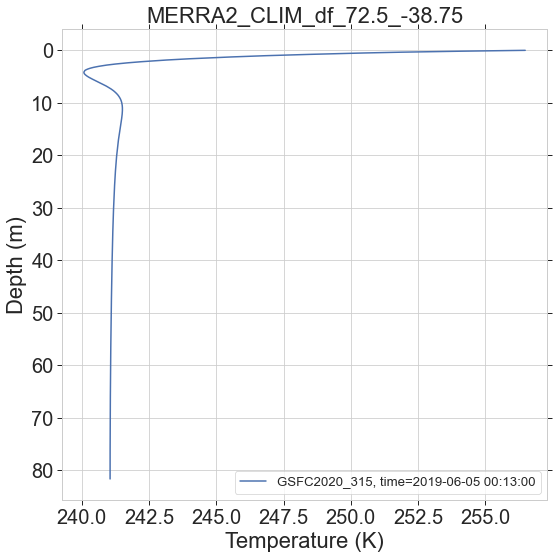

In [9]:
# Plot temperature with depth
f1,a1=plt.subplots(figsize=(8,8))
for physics_rv in rd.keys():
    rd[physics_rv]['Datetime'] = pd.to_datetime([decyeartodatetime(iii) for iii in rd[physics_rv]['model_time']])
    itime = np.where(rd['GSFC2020_315']['Datetime']>='2019-06')[0][0]
    a1.plot(rd[physics_rv]['temperature'][itime,:],rd[physics_rv]['depth'][itime,:],label=f'{physics_rv}, time={rd[physics_rv]["Datetime"][itime]}')
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Temperature (K)')
a1.set_ylabel('Depth (m)')
a1.set_title(f'{data_source}_{lat_val}_{lon_val}')

figfilename = f'{data_source}_{lat_val}_{lon_val}_Temp_Depth.png'
f1.savefig(figfilename)

In [10]:
#Using the observed Summit firn temperature data

### Flip the data frame order so that the data from shallowest thermistor (aka RTD) is the first column in the 
### data frame, and deepest is last
### and get rid of the data from the thermistors that were above surface at time of installation

Summit_rtd_depths=Summit_rtd_depths.iloc[:,::-1].drop(['rtd23','rtd22','rtd21','rtd20','rtd19','rtd18'],axis=1)
Summit_temps = Summit_temps.iloc[:,::-1].drop(['rtd23','rtd22','rtd21','rtd20','rtd19','rtd18'],axis=1)

### The sonic ranger time series has a bunch of missing data, so we fill that in with a linear interpolation
### which gives us a new data frame of the rtd depths without a bunch of nans
deltaseries = Summit_sonic.interpolate().delta
rtd_depths_filled = pd.DataFrame((-1*deltaseries.values[:,None]+Summit_rtd_depths.iloc[0].values[None,:]),columns = Summit_rtd_depths.columns, index = Summit_sonic.index)

In [11]:
## Interpolate the data onto a regularly spaced grid

grid_res = 0.1 #resolution of our interpolated grid, i.e we will interpolate onto a regular grid of 0.0, 0.1, 0.2, etc.
n_grid = np.arange(0,13+grid_res,grid_res) # n_grid is our regular grid
t_interp_data=np.zeros((rtd_depths_filled.shape[0],len(n_grid))) # initialize a matrix that will hold the interpolated temperatures
time = Summit_temps.index # time of observations

for kk in range(rtd_depths_filled.shape[0]): # loop through each day of observations and do the interpolation
    tif = sp.interpolate.interp1d(rtd_depths_filled.iloc[kk].values, Summit_temps.iloc[kk].values, bounds_error=False) #scipy interpolation has you first create a function
    t_interp_data[kk,:]= tif(n_grid) #apply the interpolation function
    
temps_interpolated_data = pd.DataFrame(t_interp_data,index = Summit_temps.index,columns=n_grid) #put the interpolated temperatures into a data frame

C:\Users\dswan1\AppData\Local\Temp\1\ipykernel_3980\2614214074.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = f1.colorbar(cax1)


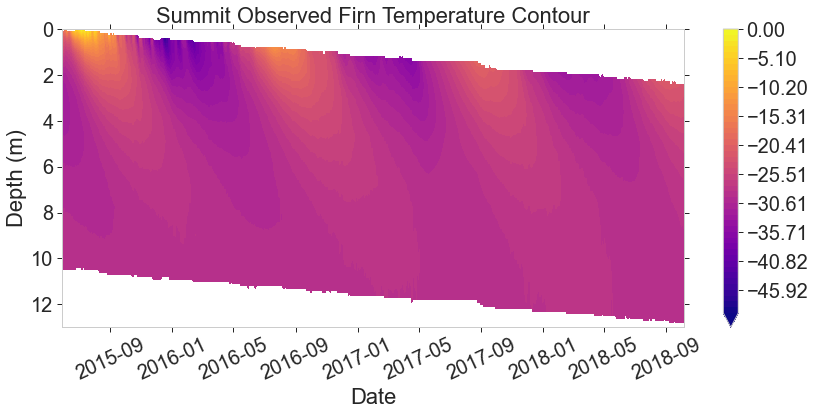

In [12]:
### Plot a contour of observed firn temperature from Summit

f1,a1=plt.subplots(figsize=(12,6))
plt.grid(False)
levels = np.linspace(-50, 0, 50)
cax1 = a1.contourf(time,n_grid,t_interp_data.T, 50,extend = 'min', 
                        levels = levels, zorder=0, 
                        cmap='plasma')
a1.invert_yaxis()
a1.set_xlabel('Date')
a1.tick_params(axis='x', rotation=25)
a1.set_ylabel('Depth (m)')
a1.set_title(f'Summit Observed Firn Temperature Contour')
a1.set_label('Firn temperature ($^o$C)')
cb1 = f1.colorbar(cax1)
figfilename = f'Contour_Observed_Firn_Temp_GSFC_{rvs}.png'
f1.savefig(figfilename)

In [13]:
## Interpolate the data onto a regularly spaced grid
t_interp_mod =np.zeros((y_df.shape[0],len(n_grid)))
time_mod = x_df # time of observations

for kk in range(y_df.shape[0]): # loop through each day of observations and do the interpolation
    tif = sp.interpolate.interp1d(y_df[kk], z_df[kk], bounds_error=False) #scipy interpolation has you first create a function
    t_interp_mod[kk,:]= tif(n_grid) #apply the interpolation function
    
temps_interpolated_model = pd.DataFrame(t_interp_mod,index = pd.to_datetime([decyeartodatetime(dd) for dd in rd[physics_rv]['model_time']]),columns=n_grid) #put the interpolated temperatures into a data frame

C:\Users\dswan1\AppData\Local\Temp\1\ipykernel_3980\2698503127.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = f1.colorbar(cax1)


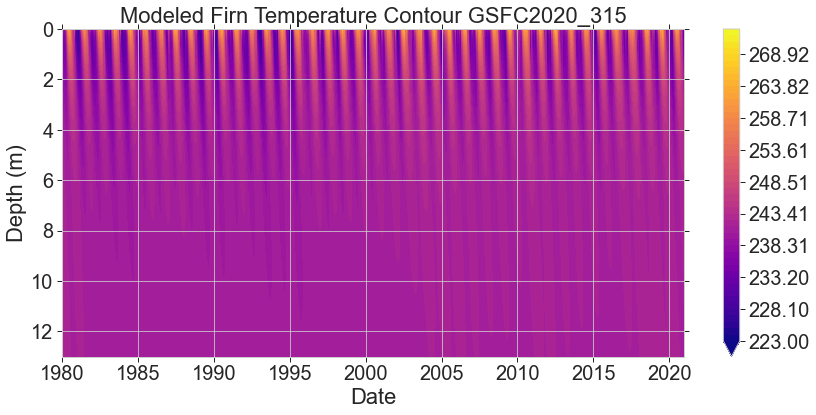

In [14]:
### Plot a contour of the modeled firn temperature for the model run specified 

f1,a1=plt.subplots(figsize=(12,6))
levels = np.linspace(223, 273, 50)
cax1 = a1.contourf(time_mod,n_grid,t_interp_mod.T, 50,extend = 'min', 
                        levels = levels, zorder=0, 
                        cmap='plasma')
a1.invert_yaxis()
a1.set_xlabel('Date')
a1.set_ylabel('Depth (m)')
a1.set_title(f'Modeled Firn Temperature Contour {physics_rv}')
a1.set_label('Firn temperature ($^o$C)')
cb1 = f1.colorbar(cax1)
figfilename = f'Contour_Modeled_Firn_Temp_GSFC_{rvs}.png'
f1.savefig(figfilename)

In [15]:
## Comparing the Observed data to the Modeled outputs

#hte model outputs
temps_interpolated_model = pd.DataFrame(t_interp_mod,index = pd.to_datetime([decyeartodatetime(dd) for dd in rd[physics_rv]['model_time']]),columns=n_grid) #put the interpolated temperatures into a data frame
temps_interpolated_model.index=temps_interpolated_model.index.round('D') # .index.round('D') = round to the nearest day because we are using decimal dates that are slightly off from each day

#hte data
temps_interpolated_data = pd.DataFrame(t_interp_data,index = Summit_temps.index,columns=n_grid) #put the interpolated temperatures into a data frame

#find the difference between the modeled and the observed
overlaping_dates = temps_interpolated_data.index.intersection(temps_interpolated_model.index) # the dates that we have both model output and data
temps_data_subsampled = temps_interpolated_data.loc[overlaping_dates] #Select just the data from the overlaping dates
temps_model_subsampled = temps_interpolated_model.loc[overlaping_dates] #Select just the model outputs from the overlaping dates

temps_difference = ((temps_model_subsampled-273.15) - temps_data_subsampled) # We can then look at the difference between the model and data

#find the 10 m difference between the modeled and the observed 
temps_difference_10m = ((temps_model_subsampled.iloc[:,100]-273.15) - temps_data_subsampled.iloc[:,100])

C:\Users\dswan1\AppData\Local\Temp\1\ipykernel_3980\289850734.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = f1.colorbar(cax1, ticks=cbar_ticks)


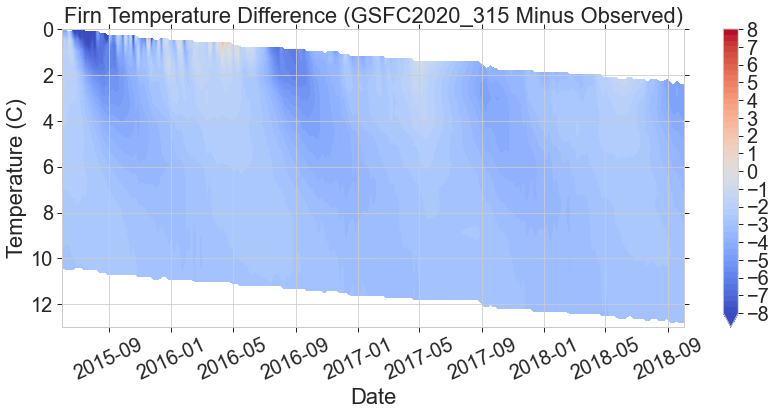

In [16]:
#Plot the firn temperature difference (modeled minus the observed)

f1,a1=plt.subplots(figsize=(12,6))
tmin = -8
tmax = 8
levels = np.linspace(tmin, tmax, 50)
cbar_ticks = np.linspace(tmin,tmax,tmax-tmin+1)
cax1 = a1.contourf(overlaping_dates,n_grid,temps_difference.T, 50,extend = 'min', 
                        levels = levels, zorder=0, 
                        cmap='coolwarm')
a1.invert_yaxis()
a1.set_xlabel('Date')
a1.tick_params(axis='x', rotation=25)
a1.set_ylabel('Temperature (C)')
a1.set_title(f'Firn Temperature Difference ({physics_rv} Minus Observed)')
a1.set_label('Firn temperature')
cb1 = f1.colorbar(cax1, ticks=cbar_ticks)
figfilename = f'Contour_Firn_Temp_Diff_GSFC_{rvs}.png'
f1.savefig(figfilename)

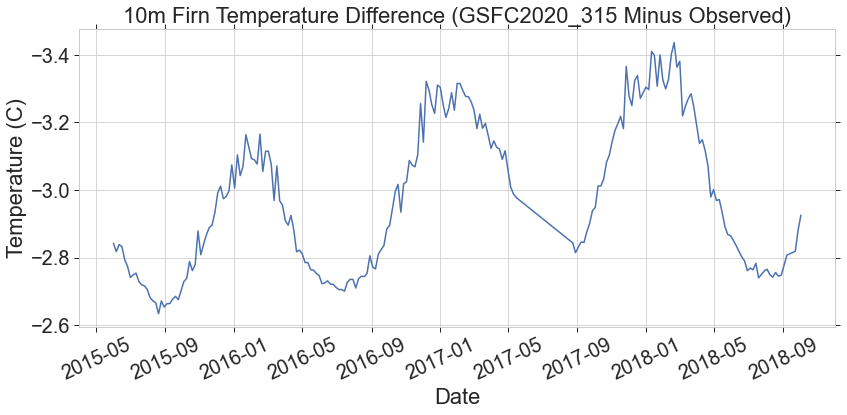

In [17]:
#Plot the 10m firn temperature difference (modeled minus observed)

f1,a1=plt.subplots(figsize=(12,6))
a1.plot(overlaping_dates, temps_difference_10m)
a1.invert_yaxis()
a1.set_xlabel('Date')
a1.tick_params(axis='x', rotation=25)
a1.set_ylabel('Temperature (C)')
a1.set_title(f'10m Firn Temperature Difference ({physics_rv} Minus Observed)')
a1.set_label('Firn temperature')
figfilename = f'10m_Firn_Temp_Diff_GSFC_{rvs}.png'
f1.savefig(figfilename)

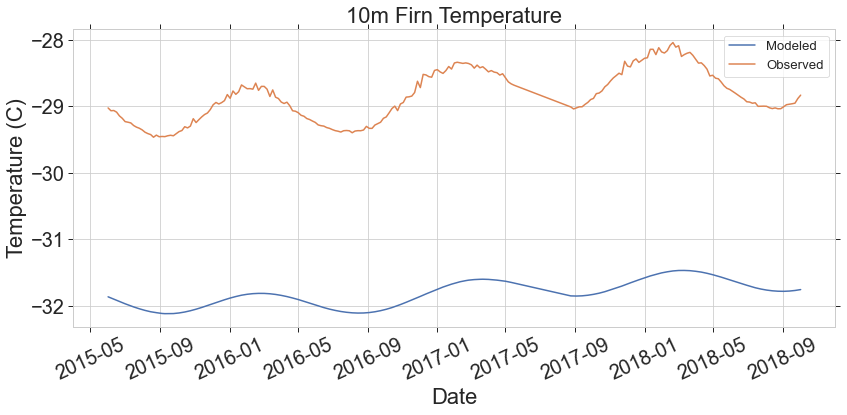

In [18]:
#Plot the 10m (modeled and observed) firn temperature

f1,a1=plt.subplots(figsize=(12,6))
a1.plot(overlaping_dates, temps_model_subsampled.iloc[:,100]-273.15, label = f'Modeled')
a1.plot(overlaping_dates, temps_data_subsampled.iloc[:,100], label = f'Observed')
a1.legend()
a1.set_xlabel('Date')
a1.tick_params(axis='x', rotation=25)
a1.set_ylabel('Temperature (C)')
a1.set_title(f'10m Firn Temperature')
a1.set_label('Firn temperature')
figfilename = f'10m_Firn_Temp_GSFC_{rvs}.png'
f1.savefig(figfilename)

In [19]:
# Comparing the Modeled t_adjust firn temp to the Modeled firn temp

#Modeled outputs t_adjust
t_interp_mod_Tplus =np.zeros((y_df_Tplus.shape[0],len(n_grid))) # initialize a matrix that will hold the interpolated temperatures

for rr in range(y_df_Tplus.shape[0]): # loop through each day of observations and do the interpolation
    tif_Tplus = sp.interpolate.interp1d(y_df_Tplus[rr], z_df_Tplus[rr], bounds_error=False) #scipy interpolation has you first create a function
    t_interp_mod_Tplus[rr,:]= tif_Tplus(n_grid) #apply the interpolation function   
    
temps_interpolated_mod_Tplus = pd.DataFrame(t_interp_mod_Tplus,index = pd.to_datetime([decyeartodatetime(dd) for dd in rd2[physics_rv]['model_time']]),columns=n_grid) #put the interpolated temperatures into a data frame
temps_interpolated_mod_Tplus.index=temps_interpolated_mod_Tplus.index.round('D') # .index.round('D') = round to the nearest day because we are using decimal dates that are slightly off from each day

#look at the model/data difference
temps_model_subsampled_Tplus = temps_interpolated_mod_Tplus.loc[overlaping_dates] #Select just the model outputs from the overlaping dates

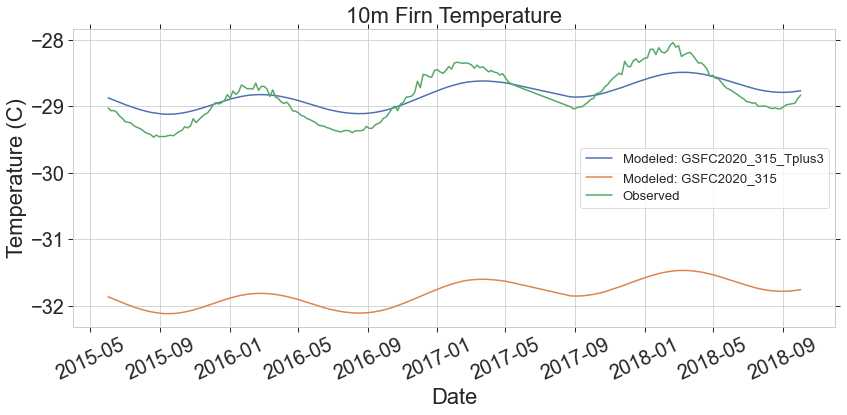

In [24]:
# Plot the Modeled with t_adjust, Modeled, and Observed 10m firn temperature
f1,a1=plt.subplots(figsize=(12,6))
a1.plot(overlaping_dates, temps_model_subsampled_Tplus.iloc[:,100]-273.15, label = f'Modeled: GSFC2020_315_Tplus{t_adjust}')
a1.plot(overlaping_dates, temps_model_subsampled.iloc[:,100]-273.15, label = f'Modeled: GSFC2020_315')
a1.plot(overlaping_dates, temps_data_subsampled.iloc[:,100], label = f'Observed')
a1.legend()
a1.set_xlabel('Date')
a1.tick_params(axis='x', rotation=25)
a1.set_ylabel('Temperature (C)')
a1.set_title(f'10m Firn Temperature')
figfilename = f'10m_Firn_Temp_GSFC_{rvs}_ModeledTplus_{t_adjust}.png'
f1.savefig(figfilename)

Text(0.5, 1.0, 'GSFC2020_315 FAC')

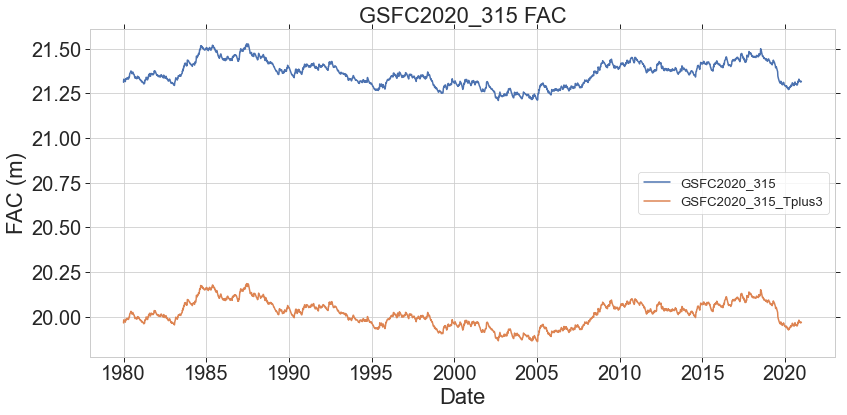

In [26]:
#Plot the specified model FAC with the t_adjust modeled output

f1,a1=plt.subplots(figsize=(12,6))
a1.plot(rd[physics_rv]['Datetime'][:],rd[physics_rv]['DIP'][:,0],label=f'GSFC2020_315')
a1.plot(rd2[physics_rv]['Datetime'][:],rd2[physics_rv]['DIP'][:,0],label=f'GSFC2020_315_Tplus{t_adjust}')
a1.legend()
a1.set_xlabel('Date')
a1.set_ylabel('FAC (m)')
a1.set_title(f'GSFC2020_315 FAC')

In [22]:
### Compare FirnCover air temp to MERRA2 data

overlap_dates = df_daily.index.intersection(Summit_air_temp.index)
df_daily_subsampled = df_daily.loc[overlap_dates] #Select just the data from the overlaping dates
Summit_air_subsampled = Summit_air_temp.loc[overlap_dates]

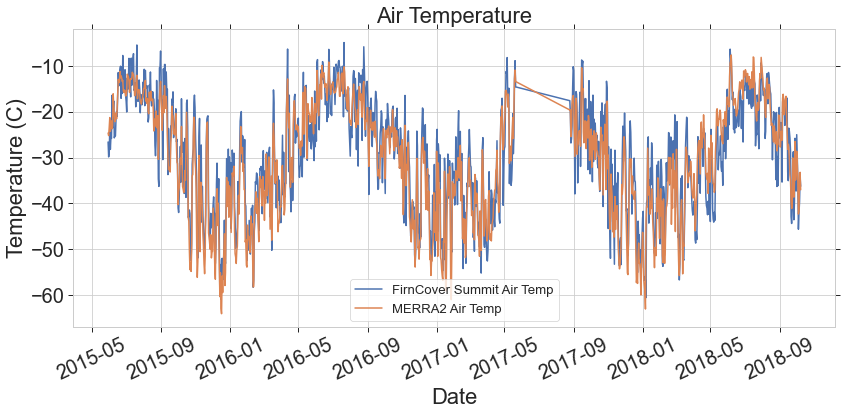

In [23]:
# Plot the FirnCover Summit air temp with the MERAA2 air temp

f1,a1=plt.subplots(figsize=(12,6))
a1.plot(overlap_dates, Summit_air_subsampled['air_temp_C'], label=f'FirnCover Summit Air Temp')
a1.plot(overlap_dates, df_daily_subsampled['TS']-273.15, label=f'MERRA2 Air Temp')
a1.tick_params(axis='x', rotation=25)
a1.legend()
a1.set_xlabel('Date')
a1.set_ylabel('Temperature (C)')
a1.set_title(f'Air Temperature')
figfilename = f'FirnCover_MERRA2_Air_Temp.png'
f1.savefig(figfilename)